## 1. Importación de librerías (ACTUALIZADA)


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import json
import mysql.connector
from mysql.connector import Error as MySQLError, errorcode
import base64
from datetime import datetime
from tkinter import filedialog, simpledialog
from tkinter import Tk
import tkinter.messagebox as messagebox
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías importadas correctamente")
print("📚 Librerías agregadas: json, mysql.connector, base64, datetime")


✅ Librerías importadas correctamente
📚 Librerías agregadas: json, mysql.connector, base64, datetime


## 2. Configuración de Base de Datos


In [3]:
# Configuración de conexión MySQL
MYSQL_CONFIG = {
    'host': 'localhost',
    'port': 3306,
    'user': 'root',
    'password': '@dmin',
    'database': 'reconocimiento_facial',
    'charset': 'utf8mb4',
    'collation': 'utf8mb4_unicode_ci'
}

def crear_conexion_mysql():
    """Crear conexión a MySQL"""
    try:
        connection = mysql.connector.connect(**MYSQL_CONFIG)
        if connection.is_connected():
            return connection
    except MySQLError as e:
        print(f"❌ Error conectando a MySQL: {e}")
        return None

def agregar_columna_id_estudiante():
    """Agregar la columna ID_Estudiante a la tabla PERSONAS si no existe"""
    connection = None
    try:
        connection = crear_conexion_mysql()
        if not connection:
            return False

        cursor = connection.cursor()

        # Verificar si la columna ya existe
        cursor.execute("""
            SELECT COUNT(*)
            FROM INFORMATION_SCHEMA.COLUMNS
            WHERE TABLE_SCHEMA = %s
            AND TABLE_NAME = 'PERSONAS'
            AND COLUMN_NAME = 'ID_Estudiante'
        """, (MYSQL_CONFIG['database'],))

        existe_columna = cursor.fetchone()[0] > 0

        if not existe_columna:
            # Agregar la nueva columna
            cursor.execute("""
                ALTER TABLE PERSONAS
                ADD COLUMN ID_Estudiante VARCHAR(20) UNIQUE AFTER Correo,
                ADD INDEX idx_id_estudiante (ID_Estudiante)
            """)
            connection.commit()
            print("✅ Columna ID_Estudiante agregada correctamente")
        else:
            print("✅ Columna ID_Estudiante ya existe")

        cursor.close()
        connection.close()
        return True

    except MySQLError as e:
        print(f"❌ Error agregando columna ID_Estudiante: {e}")
        if connection and connection.is_connected():
            connection.rollback()
        return False
    finally:
        if connection and connection.is_connected():
            connection.close()

def inicializar_base_datos():
    """Inicializar la base de datos MySQL con la tabla PERSONAS"""
    try:
        # Primero crear la base de datos si no existe
        config_sin_db = MYSQL_CONFIG.copy()
        del config_sin_db['database']

        connection = mysql.connector.connect(**config_sin_db)
        cursor = connection.cursor()

        # Crear base de datos
        cursor.execute(f"CREATE DATABASE IF NOT EXISTS {MYSQL_CONFIG['database']} "
                      f"CHARACTER SET {MYSQL_CONFIG['charset']} "
                      f"COLLATE {MYSQL_CONFIG['collation']}")

        print(f"✅ Base de datos '{MYSQL_CONFIG['database']}' verificada/creada")
        cursor.close()
        connection.close()

        # Ahora conectar a la base de datos específica
        connection = crear_conexion_mysql()
        if not connection:
            return False

        cursor = connection.cursor()

        # Crear tabla PERSONAS con ID_Estudiante incluido
        crear_tabla_personas = """
            CREATE TABLE IF NOT EXISTS PERSONAS (
                ID INT AUTO_INCREMENT PRIMARY KEY,
                Nombre VARCHAR(100) NOT NULL,
                Apellidos VARCHAR(100) NOT NULL,
                Correo VARCHAR(255) UNIQUE NOT NULL,
                ID_Estudiante VARCHAR(20) UNIQUE,
                Foto LONGTEXT,
                PK VARCHAR(50) UNIQUE NOT NULL,
                fecha_registro TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                activo BOOLEAN DEFAULT TRUE,
                INDEX idx_correo (Correo),
                INDEX idx_id_estudiante (ID_Estudiante),
                INDEX idx_pk (PK)
            ) ENGINE=InnoDB CHARACTER SET utf8mb4 COLLATE utf8mb4_unicode_ci
        """

        cursor.execute(crear_tabla_personas)

        # Crear tabla para almacenar características faciales
        crear_tabla_caracteristicas = """
            CREATE TABLE IF NOT EXISTS CARACTERISTICAS_FACIALES (
                ID INT AUTO_INCREMENT PRIMARY KEY,
                persona_id INT NOT NULL,
                caracteristicas_json LONGTEXT NOT NULL,
                umbral_similitud DECIMAL(3,2) DEFAULT 0.75,
                metodo VARCHAR(50) DEFAULT 'opencv_tradicional',
                fecha_creacion TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                FOREIGN KEY (persona_id) REFERENCES PERSONAS(ID) ON DELETE CASCADE,
                INDEX idx_persona_id (persona_id)
            ) ENGINE=InnoDB CHARACTER SET utf8mb4 COLLATE utf8mb4_unicode_ci
        """

        cursor.execute(crear_tabla_caracteristicas)

        connection.commit()
        cursor.close()
        connection.close()

        # Agregar columna ID_Estudiante si la tabla ya existía sin ella
        agregar_columna_id_estudiante()

        print("✅ Tablas MySQL inicializadas correctamente")
        print(f"📁 Host: {MYSQL_CONFIG['host']}:{MYSQL_CONFIG['port']}")
        print(f"📊 Base de datos: {MYSQL_CONFIG['database']}")
        print("🎓 Columna ID_Estudiante disponible")
        return True

    except MySQLError as e:
        print(f"❌ Error inicializando base de datos MySQL: {e}")
        if 'connection' in locals() and connection.is_connected():
            connection.close()
        return False

# Inicializar base de datos MySQL
inicializar_base_datos()


✅ Base de datos 'reconocimiento_facial' verificada/creada
✅ Columna ID_Estudiante ya existe
✅ Tablas MySQL inicializadas correctamente
📁 Host: localhost:3306
📊 Base de datos: reconocimiento_facial
🎓 Columna ID_Estudiante disponible


True

## 3. Funciones auxiliares mejoradas


In [4]:
def seleccionar_imagen(titulo="Seleccionar imagen"):
    """Abre un diálogo para seleccionar una imagen"""
    root = Tk()
    root.withdraw()
    root.attributes('-topmost', True)

    archivo = filedialog.askopenfilename(
        title=titulo,
        filetypes=[
            ("Archivos de imagen", "*.jpg *.jpeg *.png *.bmp *.gif"),
            ("Todos los archivos", "*.*")
        ]
    )
    root.destroy()
    return archivo

def cargar_imagen(ruta_imagen):
    """Carga una imagen desde una ruta específica"""
    if not ruta_imagen:
        print("❌ No se seleccionó ninguna imagen")
        return None

    imagen = cv2.imread(ruta_imagen)
    if imagen is None:
        print(f"❌ Error: No se pudo cargar la imagen desde {ruta_imagen}")
        return None

    print(f"✅ Imagen cargada correctamente: {os.path.basename(ruta_imagen)}")
    return imagen, ruta_imagen

def imagen_a_base64(ruta_imagen):
    """Convierte una imagen a base64 para almacenar en la base de datos"""
    try:
        with open(ruta_imagen, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode('utf-8')
    except Exception as e:
        print(f"❌ Error convirtiendo imagen a base64: {e}")
        return None

def base64_a_imagen(base64_string, ruta_salida):
    """Convierte base64 a imagen"""
    try:
        img_data = base64.b64decode(base64_string)
        with open(ruta_salida, 'wb') as img_file:
            img_file.write(img_data)
        return True
    except Exception as e:
        print(f"❌ Error convirtiendo base64 a imagen: {e}")
        return False

def generar_pk_unico():
    """Genera una clave primaria única basada en timestamp"""
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    import random
    random_num = random.randint(1000, 9999)
    return f"PK_{timestamp}_{random_num}"

def validar_id_estudiante(id_estudiante):
    """Valida que el ID de estudiante tenga el formato correcto"""
    if not id_estudiante:
        return False

    # Eliminar espacios y convertir a string
    id_estudiante = str(id_estudiante).strip()

    # Verificar que solo contenga dígitos y tenga entre 6 y 20 caracteres
    if not id_estudiante.isdigit() or len(id_estudiante) < 6 or len(id_estudiante) > 20:
        return False

    return True

def verificar_id_estudiante_unico(id_estudiante):
    """Verifica si el ID de estudiante ya está registrado"""
    connection = None
    try:
        connection = crear_conexion_mysql()
        if not connection:
            return False

        cursor = connection.cursor()

        query = "SELECT COUNT(*) FROM PERSONAS WHERE ID_Estudiante = %s AND activo = TRUE"
        cursor.execute(query, (id_estudiante,))

        existe = cursor.fetchone()[0] > 0

        cursor.close()
        connection.close()

        return not existe  # Retorna True si NO existe (es único)

    except MySQLError as e:
        print(f"❌ Error verificando ID de estudiante: {e}")
        return False
    finally:
        if connection and connection.is_connected():
            connection.close()

def solicitar_datos_persona():
    """Solicita los datos de la persona mediante diálogos (ACTUALIZADA)"""
    root = Tk()
    root.withdraw()
    root.attributes('-topmost', True)

    try:
        nombre = simpledialog.askstring("Datos de la persona", "Ingresa el nombre:")
        if not nombre:
            return None

        apellidos = simpledialog.askstring("Datos de la persona", "Ingresa los apellidos:")
        if not apellidos:
            return None

        correo = simpledialog.askstring("Datos de la persona", "Ingresa el correo electrónico:")
        if not correo or '@' not in correo:
            messagebox.showerror("Error", "Correo electrónico inválido")
            return None

        # Solicitar ID de estudiante
        while True:
            id_estudiante = simpledialog.askstring(
                "ID de Estudiante",
                "Ingresa el ID de estudiante (6-20 dígitos, ej: 000243425):"
            )

            if not id_estudiante:
                if messagebox.askyesno("Confirmar", "¿Deseas continuar sin ID de estudiante?"):
                    id_estudiante = None
                    break
                else:
                    continue

            # Validar formato
            if not validar_id_estudiante(id_estudiante):
                messagebox.showerror(
                    "Error",
                    "ID de estudiante inválido.\nDebe contener solo dígitos y tener entre 6-20 caracteres."
                )
                continue

            # Verificar que sea único
            if not verificar_id_estudiante_unico(id_estudiante):
                messagebox.showerror("Error", "Este ID de estudiante ya está registrado.")
                continue

            break

        pk = generar_pk_unico()

        return {
            'nombre': nombre.strip(),
            'apellidos': apellidos.strip(),
            'correo': correo.strip().lower(),
            'id_estudiante': id_estudiante,
            'pk': pk
        }

    except Exception as e:
        print(f"❌ Error solicitando datos: {e}")
        return None
    finally:
        root.destroy()


## 4. Funciones de manejo de base de datos


In [5]:
def insertar_persona_bd(datos_persona, ruta_foto, caracteristicas_faciales):
    """Inserta una nueva persona en la base de datos MySQL (ACTUALIZADA)"""
    connection = None
    try:
        connection = crear_conexion_mysql()
        if not connection:
            return None

        cursor = connection.cursor()

        # Convertir foto a base64
        foto_base64 = imagen_a_base64(ruta_foto)
        if not foto_base64:
            print("❌ Error procesando la foto")
            return None

        # Insertar persona con ID_Estudiante
        query_persona = """
            INSERT INTO PERSONAS (Nombre, Apellidos, Correo, ID_Estudiante, Foto, PK)
            VALUES (%s, %s, %s, %s, %s, %s)
        """

        cursor.execute(query_persona, (
            datos_persona['nombre'],
            datos_persona['apellidos'],
            datos_persona['correo'],
            datos_persona.get('id_estudiante'),  # Puede ser None
            foto_base64,
            datos_persona['pk']
        ))

        persona_id = cursor.lastrowid

        # Convertir características a JSON
        caracteristicas_json = json.dumps(caracteristicas_faciales.tolist())

        # Insertar características faciales
        query_caracteristicas = """
            INSERT INTO CARACTERISTICAS_FACIALES (persona_id, caracteristicas_json)
            VALUES (%s, %s)
        """

        cursor.execute(query_caracteristicas, (persona_id, caracteristicas_json))

        connection.commit()
        cursor.close()
        connection.close()

        print(f"✅ Persona insertada en MySQL con ID: {persona_id}")
        if datos_persona.get('id_estudiante'):
            print(f"🎓 ID Estudiante: {datos_persona['id_estudiante']}")
        return persona_id

    except MySQLError as e:
        if e.errno == errorcode.ER_DUP_ENTRY:
            print(f"❌ Error: El correo, ID de estudiante o PK ya existe en la base de datos")
        else:
            print(f"❌ Error MySQL insertando persona: {e}")
        return None
    except Exception as e:
        print(f"❌ Error insertando en BD: {e}")
        return None
    finally:
        if connection and connection.is_connected():
            connection.close()

def buscar_persona_por_correo(correo):
    """Busca una persona por correo electrónico (ACTUALIZADA)"""
    connection = None
    try:
        connection = crear_conexion_mysql()
        if not connection:
            return None

        cursor = connection.cursor()

        query = """
            SELECT p.*, c.caracteristicas_json, c.umbral_similitud, c.metodo
            FROM PERSONAS p
            LEFT JOIN CARACTERISTICAS_FACIALES c ON p.ID = c.persona_id
            WHERE p.Correo = %s AND p.activo = TRUE
        """

        cursor.execute(query, (correo.lower(),))
        resultado = cursor.fetchone()

        cursor.close()
        connection.close()

        if resultado:
            return {
                'id': resultado[0],
                'nombre': resultado[1],
                'apellidos': resultado[2],
                'correo': resultado[3],
                'id_estudiante': resultado[4],  # Nueva columna
                'foto': resultado[5],
                'pk': resultado[6],
                'fecha_registro': resultado[7],
                'activo': resultado[8],
                'caracteristicas': json.loads(resultado[9]) if resultado[9] else None,
                'umbral': float(resultado[10]) if resultado[10] else 0.75,
                'metodo': resultado[11] if resultado[11] else 'opencv_tradicional'
            }
        return None

    except MySQLError as e:
        print(f"❌ Error MySQL buscando persona: {e}")
        return None
    except Exception as e:
        print(f"❌ Error buscando persona: {e}")
        return None
    finally:
        if connection and connection.is_connected():
            connection.close()

def buscar_persona_por_id_estudiante(id_estudiante):
    """Busca una persona por ID de estudiante"""
    connection = None
    try:
        connection = crear_conexion_mysql()
        if not connection:
            return None

        cursor = connection.cursor()

        query = """
            SELECT p.*, c.caracteristicas_json, c.umbral_similitud, c.metodo
            FROM PERSONAS p
            LEFT JOIN CARACTERISTICAS_FACIALES c ON p.ID = c.persona_id
            WHERE p.ID_Estudiante = %s AND p.activo = TRUE
        """

        cursor.execute(query, (id_estudiante,))
        resultado = cursor.fetchone()

        cursor.close()
        connection.close()

        if resultado:
            return {
                'id': resultado[0],
                'nombre': resultado[1],
                'apellidos': resultado[2],
                'correo': resultado[3],
                'id_estudiante': resultado[4],
                'foto': resultado[5],
                'pk': resultado[6],
                'fecha_registro': resultado[7],
                'activo': resultado[8],
                'caracteristicas': json.loads(resultado[9]) if resultado[9] else None,
                'umbral': float(resultado[10]) if resultado[10] else 0.75,
                'metodo': resultado[11] if resultado[11] else 'opencv_tradicional'
            }
        return None

    except MySQLError as e:
        print(f"❌ Error MySQL buscando persona por ID estudiante: {e}")
        return None
    except Exception as e:
        print(f"❌ Error buscando persona por ID estudiante: {e}")
        return None
    finally:
        if connection and connection.is_connected():
            connection.close()

def listar_todas_personas():
    """Lista todas las personas registradas (ACTUALIZADA)"""
    connection = None
    try:
        connection = crear_conexion_mysql()
        if not connection:
            return []

        cursor = connection.cursor()

        query = """
            SELECT ID, Nombre, Apellidos, Correo, ID_Estudiante, PK, fecha_registro
            FROM PERSONAS
            WHERE activo = TRUE
            ORDER BY fecha_registro DESC
        """

        cursor.execute(query)
        resultados = cursor.fetchall()

        cursor.close()
        connection.close()

        return resultados

    except MySQLError as e:
        print(f"❌ Error MySQL listando personas: {e}")
        return []
    except Exception as e:
        print(f"❌ Error listando personas: {e}")
        return []
    finally:
        if connection and connection.is_connected():
            connection.close()


def guardar_json_backup(datos_persona, caracteristicas, ruta_foto):
    """Guarda un backup en JSON de los datos de la persona"""
    try:
        # Crear directorio para JSON si no existe
        if not os.path.exists('json_backup'):
            os.makedirs('json_backup')

        # Preparar datos para JSON
        datos_completos = {
            'datos_personales': datos_persona,
            'caracteristicas_faciales': caracteristicas.tolist(),
            'metadata': {
                'fecha_creacion': datetime.now().isoformat(),
                'archivo_foto_original': os.path.basename(ruta_foto),
                'total_caracteristicas': len(caracteristicas),
                'metodo_extraccion': 'opencv_tradicional',
                'umbral_similitud': 0.75,
                'base_datos': 'MySQL'
            }
        }

        # Guardar archivo JSON
        nombre_archivo = f"json_backup/persona_{datos_persona['pk']}.json"
        with open(nombre_archivo, 'w', encoding='utf-8') as f:
            json.dump(datos_completos, f, indent=2, ensure_ascii=False)

        print(f"💾 Backup JSON guardado: {nombre_archivo}")
        return nombre_archivo

    except Exception as e:
        print(f"❌ Error guardando JSON backup: {e}")
        return None


## 5. Funciones de extracción de características (mantenidas)


In [6]:
def calcular_lbp(imagen, radio=1, n_puntos=8):
    """Calcula Local Binary Pattern para características de textura"""
    lbp = np.zeros_like(imagen)
    for i in range(radio, imagen.shape[0] - radio):
        for j in range(radio, imagen.shape[1] - radio):
            centro = imagen[i, j]
            valor_lbp = 0
            for k in range(n_puntos):
                angulo = 2 * np.pi * k / n_puntos
                x_coord = int(i + radio * np.cos(angulo))
                y_coord = int(j + radio * np.sin(angulo))
                if imagen[x_coord, y_coord] >= centro:
                    valor_lbp += 2 ** k
            lbp[i, j] = valor_lbp
    return lbp


## 6. Proceso completo de registro (NUEVO)


In [7]:
def proceso_completo_registro():
    """Proceso completo de registro de una persona nueva en MySQL"""
    print("🆕 INICIANDO PROCESO DE REGISTRO COMPLETO - MYSQL")
    print("=" * 55)

    # Paso 1: Solicitar datos personales
    print("📝 Paso 1: Solicitando datos personales...")
    datos_persona = solicitar_datos_persona()
    if not datos_persona:
        print("❌ Registro cancelado - no se proporcionaron datos")
        return None

    # Verificar si ya existe el correo
    persona_existente = buscar_persona_por_correo(datos_persona['correo'])
    if persona_existente:
        print(f"❌ Ya existe una persona registrada con el correo: {datos_persona['correo']}")
        return None

    print(f"✅ Datos recibidos para: {datos_persona['nombre']} {datos_persona['apellidos']}")

    # Paso 2: Seleccionar imagen
    print("\n📷 Paso 2: Seleccionando imagen facial...")
    ruta_imagen_ref = seleccionar_imagen("Seleccionar imagen de referencia facial")

    if not ruta_imagen_ref:
        print("❌ Registro cancelado - no se seleccionó imagen")
        return None

    resultado = cargar_imagen(ruta_imagen_ref)
    if not resultado:
        print("❌ Registro cancelado - error cargando imagen")
        return None

    imagen_color, nombre_archivo = resultado

    # Paso 3: Procesamiento de imagen
    print("\n🔄 Paso 3: Procesando imagen...")

    # Convertir a escala de grises
    imagen_gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)

    # Eliminar ruido
    imagen_gaussiana = cv2.GaussianBlur(imagen_gris, (5, 5), 0)
    imagen_sin_ruido = cv2.bilateralFilter(imagen_gaussiana, 9, 75, 75)

    # Detectar rostros
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    rostros_detectados = face_cascade.detectMultiScale(
        imagen_sin_ruido,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    if len(rostros_detectados) == 0:
        print("❌ No se detectaron rostros en la imagen")
        return None

    print(f"✅ Se detectaron {len(rostros_detectados)} rostro(s)")

    # Paso 4: Extraer características
    print("\n🧬 Paso 4: Extrayendo características faciales...")

    x, y, w, h = rostros_detectados[0]
    rostro_referencia = imagen_sin_ruido[y:y + h, x:x + w]
    rostro_redimensionado = cv2.resize(rostro_referencia, (128, 128))

    # Extraer características
    caracteristicas_pixel = rostro_redimensionado.flatten().astype(np.float32) / 255.0
    histograma = cv2.calcHist([rostro_redimensionado], [0], None, [256], [0, 256])
    caracteristicas_histograma = histograma.flatten()
    lbp_imagen = calcular_lbp(rostro_redimensionado)
    histograma_lbp = cv2.calcHist([lbp_imagen.astype(np.uint8)], [0], None, [256], [0, 256])
    caracteristicas_textura = histograma_lbp.flatten()

    caracteristicas_referencia = np.concatenate([
        caracteristicas_pixel[:512],
        caracteristicas_histograma,
        caracteristicas_textura
    ])

    print(f"✅ Se extrajeron {len(caracteristicas_referencia)} características")

    # Paso 5: Guardar en base de datos MySQL
    print("\n💾 Paso 5: Guardando en base de datos MySQL...")
    persona_id = insertar_persona_bd(datos_persona, ruta_imagen_ref, caracteristicas_referencia)

    if not persona_id:
        print("❌ Error guardando en base de datos MySQL")
        return None

    # Paso 6: Crear backup JSON
    print("\n📄 Paso 6: Creando backup JSON...")
    archivo_json = guardar_json_backup(datos_persona, caracteristicas_referencia, ruta_imagen_ref)

    # Paso 7: Guardar modelo pickle (compatibilidad)
    print("\n🗃️ Paso 7: Creando modelo pickle para compatibilidad...")
    modelo_facial = {
        'caracteristicas': caracteristicas_referencia,
        'nombre_persona': f"{datos_persona['nombre']} {datos_persona['apellidos']}",
        'umbral_similitud': 0.75,
        'imagen_referencia': nombre_archivo,
        'rostro_referencia': rostro_redimensionado,
        'metodo': 'opencv_tradicional',
        'persona_id': persona_id,
        'pk': datos_persona['pk'],
        'correo': datos_persona['correo'],
        'base_datos': 'MySQL'
    }

    if not os.path.exists('modelos'):
        os.makedirs('modelos')

    nombre_modelo = f"modelos/modelo_facial_{datos_persona['pk']}.pkl"
    with open(nombre_modelo, 'wb') as archivo:
        pickle.dump(modelo_facial, archivo)

    # Mostrar resultados
    print("\n" + "=" * 55)
    print("🎉 REGISTRO COMPLETADO EXITOSAMENTE EN MYSQL")
    print("=" * 55)
    print(f"👤 Nombre: {datos_persona['nombre']} {datos_persona['apellidos']}")
    print(f"📧 Correo: {datos_persona['correo']}")
    print(f"🔑 PK: {datos_persona['pk']}")
    print(f"🆔 ID en MySQL: {persona_id}")
    print(f"📊 Características: {len(caracteristicas_referencia)} valores")
    print(f"🗄️ Base de datos: MySQL ({MYSQL_CONFIG['host']})")
    print(f"💾 Modelo pickle: {nombre_modelo}")
    print(f"📄 Backup JSON: {archivo_json}")
    print("=" * 55)

    # Mostrar visualización
    imagen_color_rgb = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(imagen_color_rgb)
    plt.title("Imagen Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(rostro_redimensionado, cmap='gray')
    plt.title("Rostro Procesado (128x128)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.plot(caracteristicas_referencia, 'b-', alpha=0.7)
    plt.title("Vector de Características")
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.grid(True, alpha=0.3)

    plt.suptitle(f"Registro MySQL: {datos_persona['nombre']} {datos_persona['apellidos']}", fontsize=16)
    plt.tight_layout()
    plt.show()

    return {
        'persona_id': persona_id,
        'datos': datos_persona,
        'modelo_archivo': nombre_modelo,
        'json_archivo': archivo_json
    }


## 7. Funciones de consulta y reconocimiento (ACTUALIZADAS)


In [8]:
def consultar_persona_bd():
    """Interfaz para consultar personas en la base de datos MySQL (ACTUALIZADA)"""
    print("🔍 CONSULTA DE PERSONAS EN BASE DE DATOS MYSQL")
    print("=" * 55)

    # Listar todas las personas
    personas = listar_todas_personas()

    if not personas:
        print("❌ No hay personas registradas en la base de datos MySQL")
        return None

    print(f"📋 Se encontraron {len(personas)} personas registradas:")
    print()

    for i, persona in enumerate(personas, 1):
        id_estudiante_texto = persona[4] if persona[4] else "Sin ID"
        print(f"{i}. ID: {persona[0]} | {persona[1]} {persona[2]} | {persona[3]} | ID Est: {id_estudiante_texto} | PK: {persona[5]} | Registro: {persona[6]}")

    print("=" * 55)
    print("Opciones de búsqueda:")
    print("1. 📧 Buscar por correo electrónico")
    print("2. 🎓 Buscar por ID de estudiante")

    # Solicitar tipo de búsqueda
    root = Tk()
    root.withdraw()
    root.attributes('-topmost', True)

    opcion = simpledialog.askstring("Tipo de búsqueda", "Selecciona opción (1: correo, 2: ID estudiante):")

    if not opcion or opcion not in ['1', '2']:
        root.destroy()
        return None

    persona = None

    if opcion == '1':
        correo = simpledialog.askstring("Búsqueda por correo", "Ingresa el correo de la persona a consultar:")
        root.destroy()
        if correo:
            persona = buscar_persona_por_correo(correo)

    elif opcion == '2':
        id_estudiante = simpledialog.askstring("Búsqueda por ID estudiante", "Ingresa el ID de estudiante:")
        root.destroy()
        if id_estudiante:
            persona = buscar_persona_por_id_estudiante(id_estudiante)

    if not persona:
        print(f"❌ No se encontró persona con los datos proporcionados")
        return None

    # Mostrar información detallada
    print(f"\n🔍 INFORMACIÓN DETALLADA - MYSQL")
    print("-" * 40)
    print(f"🆔 ID: {persona['id']}")
    print(f"👤 Nombre: {persona['nombre']} {persona['apellidos']}")
    print(f"📧 Correo: {persona['correo']}")
    print(f"🎓 ID Estudiante: {persona['id_estudiante'] if persona['id_estudiante'] else 'No asignado'}")
    print(f"🔑 PK: {persona['pk']}")
    print(f"📅 Registro: {persona['fecha_registro']}")
    print(f"🎯 Umbral: {persona['umbral']}")
    print(f"🔧 Método: {persona['metodo']}")
    print(f"🗄️ Activo: {'Sí' if persona['activo'] else 'No'}")

    if persona['caracteristicas']:
        print(f"🧬 Características: {len(persona['caracteristicas'])} valores disponibles")
    else:
        print("❌ No hay características faciales registradas")

    return persona


def reconocimiento_desde_bd():
    """Reconocimiento facial usando datos de la base de datos MySQL"""
    print("🔍 RECONOCIMIENTO FACIAL DESDE BASE DE DATOS MYSQL")
    print("=" * 55)

    # Consultar persona
    persona = consultar_persona_bd()
    if not persona or not persona['caracteristicas']:
        print("❌ No se puede realizar reconocimiento sin características faciales")
        return None

    # Seleccionar imagen para comparar
    print(f"\n📷 Selecciona imagen para comparar con {persona['nombre']} {persona['apellidos']}:")
    ruta_imagen_test = seleccionar_imagen("Seleccionar imagen para reconocimiento")

    if not ruta_imagen_test:
        print("❌ No se seleccionó imagen para comparar")
        return None

    # Procesar imagen de prueba
    imagen_test = cv2.imread(ruta_imagen_test)
    if imagen_test is None:
        print("❌ Error cargando imagen de prueba")
        return None

    # Procesamiento estándar
    imagen_test_gris = cv2.cvtColor(imagen_test, cv2.COLOR_BGR2GRAY)
    imagen_test_sin_ruido = cv2.bilateralFilter(cv2.GaussianBlur(imagen_test_gris, (5, 5), 0), 9, 75, 75)

    # Detectar rostros
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    rostros = face_cascade.detectMultiScale(imagen_test_sin_ruido, 1.1, 5, minSize=(30, 30))

    if len(rostros) == 0:
        print("❌ No se detectaron rostros en la imagen de prueba")
        return None

    print(f"✅ Se detectaron {len(rostros)} rostro(s) en la imagen de prueba")

    # Extraer características
    x, y, w, h = rostros[0]
    rostro = imagen_test_sin_ruido[y:y+h, x:x+w]
    rostro_redimensionado = cv2.resize(rostro, (128, 128))

    caracteristicas_pixel = rostro_redimensionado.flatten().astype(np.float32) / 255.0
    histograma = cv2.calcHist([rostro_redimensionado], [0], None, [256], [0, 256]).flatten()
    lbp_img = calcular_lbp(rostro_redimensionado)
    histograma_lbp = cv2.calcHist([lbp_img.astype(np.uint8)], [0], None, [256], [0, 256]).flatten()

    caracteristicas_test = np.concatenate([
        caracteristicas_pixel[:512],
        histograma,
        histograma_lbp
    ])

    # Comparar con características de la BD MySQL
    caracteristicas_bd = np.array(persona['caracteristicas'])

    # Calcular similitud
    similitud_corr = np.corrcoef(caracteristicas_bd, caracteristicas_test)[0, 1]
    if np.isnan(similitud_corr):
        similitud_corr = 0.0

    distancia = np.linalg.norm(caracteristicas_bd - caracteristicas_test)
    similitud_dist = max(0, 1 - (distancia / np.sqrt(len(caracteristicas_test))))
    similitud = (abs(similitud_corr) + similitud_dist) / 2

    es_misma_persona = similitud >= persona['umbral']

    # Mostrar resultados
    print(f"\n📊 RESULTADOS DEL RECONOCIMIENTO - MYSQL:")
    print(f"Persona de referencia: {persona['nombre']} {persona['apellidos']}")
    print(f"Similitud calculada: {similitud:.4f}")
    print(f"Umbral configurado: {persona['umbral']}")
    print(f"Base de datos: MySQL (ID: {persona['id']})")

    if es_misma_persona:
        print(f"✅ COINCIDENCIA: La imagen pertenece a {persona['nombre']} {persona['apellidos']}")
    else:
        print(f"❌ NO COINCIDENCIA: La imagen NO pertenece a {persona['nombre']} {persona['apellidos']}")

    # Visualización
    imagen_test_rgb = cv2.cvtColor(imagen_test, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(imagen_test_rgb)
    plt.title("Imagen de Prueba")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(rostro_redimensionado, cmap='gray')
    plt.title("Rostro Extraído")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    resultado_texto = "✅ COINCIDE" if es_misma_persona else "❌ NO COINCIDE"
    color = 'green' if es_misma_persona else 'red'
    plt.text(0.5, 0.7, resultado_texto, fontsize=20, fontweight='bold',
             ha='center', va='center', color=color, transform=plt.gca().transAxes)
    plt.text(0.5, 0.4, f"Similitud: {similitud:.3f}", fontsize=16,
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.5, 0.1, f"{persona['nombre']} {persona['apellidos']}", fontsize=14,
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis("off")
    plt.title("Resultado MySQL")

    plt.subplot(2, 2, 4)
    plt.plot(caracteristicas_bd, 'b-', alpha=0.7, label='MySQL BD')
    plt.plot(caracteristicas_test, 'r-', alpha=0.7, label='Prueba')
    plt.title("Comparación de Características")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'persona': persona,
        'similitud': similitud,
        'coincide': es_misma_persona
    }


## 8. Panel de administración


In [9]:
def gestion_exportar_importar():
    """Gestión de exportación e importación de datos"""
    print("🔄 GESTIÓN DE EXPORTACIÓN/IMPORTACIÓN DE DATOS")
    print("=" * 50)
    print("1. 📤 Exportar todos los datos a JSON")
    print("2. 📤 Exportar persona específica")
    print("3. 📥 Importar datos desde JSON")
    print("4. 💾 Crear respaldo completo de MySQL")
    print("5. 🔍 Verificar sincronización BD/Archivos")
    print("=" * 50)

    opcion = input("Selecciona una opción (1-5): ").strip()

    if opcion == "1":
        return exportar_todos_datos()
    elif opcion == "2":
        return exportar_persona_especifica()
    elif opcion == "3":
        return importar_datos_json()
    elif opcion == "4":
        return crear_respaldo_mysql()
    elif opcion == "5":
        return verificar_sincronizacion()
    else:
        print("❌ Opción inválida")
        return None

def exportar_todos_datos():
    """Exporta todos los datos de MySQL a JSON"""
    try:
        connection = crear_conexion_mysql()
        if not connection:
            return None

        cursor = connection.cursor()

        # Obtener todas las personas con sus características
        query = """
            SELECT p.*, c.caracteristicas_json, c.umbral_similitud, c.metodo
            FROM PERSONAS p
            LEFT JOIN CARACTERISTICAS_FACIALES c ON p.ID = c.persona_id
            WHERE p.activo = TRUE
        """

        cursor.execute(query)
        resultados = cursor.fetchall()

        if not resultados:
            print("❌ No hay datos para exportar")
            return None

        # Crear estructura de exportación
        datos_exportacion = {
            'metadata': {
                'fecha_exportacion': datetime.now().isoformat(),
                'total_registros': len(resultados),
                'base_datos': 'MySQL',
                'host': MYSQL_CONFIG['host'],
                'version_sistema': '1.0'
            },
            'personas': []
        }

        for resultado in resultados:
            persona_data = {
                'id': resultado[0],
                'nombre': resultado[1],
                'apellidos': resultado[2],
                'correo': resultado[3],
                'foto_base64': resultado[4],
                'pk': resultado[5],
                'fecha_registro': resultado[6].isoformat() if resultado[6] else None,
                'activo': bool(resultado[7]),
                'caracteristicas': json.loads(resultado[8]) if resultado[8] else None,
                'umbral_similitud': float(resultado[9]) if resultado[9] else 0.75,
                'metodo': resultado[10] if resultado[10] else 'opencv_tradicional'
            }
            datos_exportacion['personas'].append(persona_data)

        # Guardar archivo
        if not os.path.exists('exports'):
            os.makedirs('exports')

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        nombre_archivo = f"exports/exportacion_completa_{timestamp}.json"

        with open(nombre_archivo, 'w', encoding='utf-8') as f:
            json.dump(datos_exportacion, f, indent=2, ensure_ascii=False)

        cursor.close()
        connection.close()

        print(f"✅ Exportación completa guardada: {nombre_archivo}")
        print(f"📊 {len(resultados)} personas exportadas")
        return nombre_archivo

    except Exception as e:
        print(f"❌ Error en exportación: {e}")
        return None

def exportar_persona_especifica():
    """Exporta una persona específica"""
    persona = consultar_persona_bd()
    if not persona:
        return None

    try:
        # Crear estructura de exportación individual
        datos_persona = {
            'metadata': {
                'fecha_exportacion': datetime.now().isoformat(),
                'tipo': 'persona_individual',
                'base_datos': 'MySQL'
            },
            'persona': persona
        }

        if not os.path.exists('exports'):
            os.makedirs('exports')

        nombre_archivo = f"exports/persona_{persona['pk']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

        with open(nombre_archivo, 'w', encoding='utf-8') as f:
            json.dump(datos_persona, f, indent=2, ensure_ascii=False)

        print(f"✅ Persona exportada: {nombre_archivo}")
        return nombre_archivo

    except Exception as e:
        print(f"❌ Error exportando persona: {e}")
        return None

def importar_datos_json():
    """Importa datos desde un archivo JSON"""
    print("📁 Selecciona el archivo JSON a importar:")
    archivo_json = seleccionar_archivo_json()

    if not archivo_json:
        print("❌ No se seleccionó archivo")
        return None

    try:
        with open(archivo_json, 'r', encoding='utf-8') as f:
            datos = json.load(f)

        if 'personas' in datos:
            # Importación completa
            personas = datos['personas']
            importados = 0
            errores = 0

            for persona_data in personas:
                try:
                    # Verificar si ya existe
                    existente = buscar_persona_por_correo(persona_data['correo'])
                    if existente:
                        print(f"⚠️ Saltando {persona_data['correo']} - ya existe")
                        continue

                    # Importar persona (implementar lógica de importación)
                    # Esta función requeriría más desarrollo para manejar la importación completa
                    importados += 1

                except Exception as e:
                    print(f"❌ Error importando {persona_data.get('correo', 'desconocido')}: {e}")
                    errores += 1

            print(f"✅ Importación completada: {importados} exitosos, {errores} errores")

        elif 'persona' in datos:
            # Importación individual
            print("📋 Archivo de persona individual detectado")
            # Implementar importación individual

        else:
            print("❌ Formato de archivo no reconocido")
            return None

    except Exception as e:
        print(f"❌ Error leyendo archivo JSON: {e}")
        return None

def seleccionar_archivo_json():
    """Selecciona un archivo JSON"""
    root = Tk()
    root.withdraw()
    root.attributes('-topmost', True)

    archivo = filedialog.askopenfilename(
        title="Seleccionar archivo JSON",
        filetypes=[("Archivos JSON", "*.json"), ("Todos los archivos", "*.*")]
    )
    root.destroy()
    return archivo

def crear_respaldo_mysql():
    """Crea un respaldo completo de la base de datos MySQL"""
    print("💾 Creando respaldo completo de MySQL...")

    # Esta función podría usar mysqldump o exportar manualmente
    return exportar_todos_datos()

def verificar_sincronizacion():
    """Verifica la sincronización entre BD, JSON y archivos pickle"""
    print("🔍 VERIFICANDO SINCRONIZACIÓN DEL SISTEMA")
    print("=" * 40)

    # Verificar BD MySQL
    personas_bd = listar_todas_personas()
    print(f"📊 MySQL: {len(personas_bd)} personas")

    # Verificar archivos JSON
    json_files = []
    if os.path.exists('json_backup'):
        json_files = [f for f in os.listdir('json_backup') if f.endswith('.json')]
    print(f"📄 JSON backups: {len(json_files)} archivos")

    # Verificar modelos pickle
    pkl_files = []
    if os.path.exists('modelos'):
        pkl_files = [f for f in os.listdir('modelos') if f.endswith('.pkl')]
    print(f"📦 Modelos pickle: {len(pkl_files)} archivos")

    # Verificar consistencia
    if len(personas_bd) == len(json_files) == len(pkl_files):
        print("✅ Sincronización perfecta")
    else:
        print("⚠️ Detectadas inconsistencias en la sincronización")

    print("=" * 40)

def panel_administracion():
    """Panel principal de administración del sistema"""
    print("🔧 PANEL DE ADMINISTRACIÓN - MYSQL")
    print("=" * 50)
    print("1. 🆕 Registrar nueva persona")
    print("2. 🔍 Consultar personas registradas")
    print("3. 🎯 Realizar reconocimiento facial")
    print("4. 📊 Estadísticas del sistema")
    print("5. 🗃️ Verificar integridad de archivos")
    print("6. 🔄 Exportar/Importar datos")
    print("=" * 50)

    opcion = input("Selecciona una opción (1-6): ").strip()

    if opcion == "1":
        return proceso_completo_registro()
    elif opcion == "2":
        return consultar_persona_bd()
    elif opcion == "3":
        return reconocimiento_desde_bd()
    elif opcion == "4":
        return mostrar_estadisticas()
    elif opcion == "5":
        return verificar_integridad()
    elif opcion == "6":
        return gestion_exportar_importar()
    else:
        print("❌ Opción inválida")
        return None

def mostrar_estadisticas():
    """Muestra estadísticas del sistema MySQL"""
    connection = None
    try:
        connection = crear_conexion_mysql()
        if not connection:
            return None

        cursor = connection.cursor()

        # Estadísticas básicas
        cursor.execute("SELECT COUNT(*) FROM PERSONAS WHERE activo = TRUE")
        total_personas = cursor.fetchone()[0]

        cursor.execute("SELECT COUNT(*) FROM CARACTERISTICAS_FACIALES")
        total_modelos = cursor.fetchone()[0]

        cursor.execute("SELECT MIN(fecha_registro), MAX(fecha_registro) FROM PERSONAS WHERE activo = TRUE")
        fechas = cursor.fetchone()

        # Información de la base de datos
        cursor.execute("SELECT VERSION()")
        version_mysql = cursor.fetchone()[0]

        cursor.close()
        connection.close()

        print("\n📊 ESTADÍSTICAS DEL SISTEMA MYSQL")
        print("=" * 40)
        print(f"🗄️ Base de datos: {MYSQL_CONFIG['database']}")
        print(f"🖥️ Host: {MYSQL_CONFIG['host']}:{MYSQL_CONFIG['port']}")
        print(f"📊 Versión MySQL: {version_mysql}")
        print(f"👥 Total personas registradas: {total_personas}")
        print(f"🧬 Total modelos faciales: {total_modelos}")
        print(f"📅 Primer registro: {fechas[0] if fechas[0] else 'N/A'}")
        print(f"📅 Último registro: {fechas[1] if fechas[1] else 'N/A'}")

        # Verificar archivos
        modelos_pkl = len([f for f in os.listdir('modelos') if f.endswith('.pkl')]) if os.path.exists('modelos') else 0
        backups_json = len([f for f in os.listdir('json_backup') if f.endswith('.json')]) if os.path.exists('json_backup') else 0

        print(f"📦 Archivos .pkl: {modelos_pkl}")
        print(f"📄 Backups JSON: {backups_json}")
        print("=" * 40)

    except MySQLError as e:
        print(f"❌ Error MySQL obteniendo estadísticas: {e}")
    except Exception as e:
        print(f"❌ Error obteniendo estadísticas: {e}")
    finally:
        if connection and connection.is_connected():
            connection.close()

def verificar_integridad():
    """Verifica la integridad de los archivos del sistema"""
    print("\n🔍 VERIFICANDO INTEGRIDAD DEL SISTEMA MYSQL")
    print("=" * 45)

    # Verificar conexión MySQL
    connection = crear_conexion_mysql()
    if connection:
        print("✅ Conexión MySQL establecida")
        try:
            cursor = connection.cursor()
            cursor.execute("SELECT COUNT(*) FROM PERSONAS")
            count = cursor.fetchone()[0]
            print(f"✅ Base de datos MySQL accesible ({count} registros)")
            cursor.close()
            connection.close()
        except Exception as e:
            print(f"❌ Error accediendo a MySQL: {e}")
    else:
        print("❌ No se pudo conectar a MySQL")

    # Verificar directorios
    directorios = ['modelos', 'json_backup', 'exports']
    for directorio in directorios:
        if os.path.exists(directorio):
            archivos = len(os.listdir(directorio))
            print(f"✅ Directorio {directorio}: {archivos} archivos")
        else:
            print(f"❌ Directorio {directorio}: no existe")

    print("=" * 45)


## 9. Ejemplos de uso del sistema completo


In [10]:
# Sistema completo con MySQL
print("🎯 SISTEMA DE RECONOCIMIENTO FACIAL CON MYSQL")
print("=" * 60)
print("Este sistema integra:")
print("✅ Base de datos MySQL con tabla PERSONAS")
print("✅ Almacenamiento de características en JSON")
print("✅ Compatibilidad con modelos pickle existentes")
print("✅ Manejo completo de datos personales")
print("✅ Sistema de PK únicos y validación de correos")
print("✅ Configuración MySQL: root/@dmin en puerto 3306")
print("=" * 60)

# Mostrar estadísticas iniciales
mostrar_estadisticas()


🎯 SISTEMA DE RECONOCIMIENTO FACIAL CON MYSQL
Este sistema integra:
✅ Base de datos MySQL con tabla PERSONAS
✅ Almacenamiento de características en JSON
✅ Compatibilidad con modelos pickle existentes
✅ Manejo completo de datos personales
✅ Sistema de PK únicos y validación de correos
✅ Configuración MySQL: root/@dmin en puerto 3306

📊 ESTADÍSTICAS DEL SISTEMA MYSQL
🗄️ Base de datos: reconocimiento_facial
🖥️ Host: localhost:3306
📊 Versión MySQL: 8.0.41
👥 Total personas registradas: 0
🧬 Total modelos faciales: 0
📅 Primer registro: N/A
📅 Último registro: N/A
📦 Archivos .pkl: 2
📄 Backups JSON: 2


## 10. Instrucciones de uso


In [11]:
print("\n📋 INSTRUCCIONES DE USO DEL SISTEMA MYSQL")
print("=" * 50)
print("1. 🚀 PRIMER USO:")
print("   - Las tablas MySQL se crean automáticamente")
print("   - Asegúrate de que MySQL esté ejecutándose")
print("   - Verifica las credenciales de conexión")
print()
print("2. 📝 REGISTRAR PERSONA:")
print("   proceso_completo_registro()")
print()
print("3. 🔍 CONSULTAR PERSONAS:")
print("   consultar_persona_bd()")
print()
print("4. 🎯 RECONOCIMIENTO FACIAL:")
print("   reconocimiento_desde_bd()")
print()
print("5. 🔧 PANEL COMPLETO:")
print("   panel_administracion()")
print("=" * 50)

# Verificar conexión inicial
print("\n🔍 Verificando conexión MySQL...")
connection = crear_conexion_mysql()
if connection:
    print("✅ Sistema listo para usar")
    connection.close()
else:
    print("❌ Problema de conexión - verifica MySQL")



📋 INSTRUCCIONES DE USO DEL SISTEMA MYSQL
1. 🚀 PRIMER USO:
   - Las tablas MySQL se crean automáticamente
   - Asegúrate de que MySQL esté ejecutándose
   - Verifica las credenciales de conexión

2. 📝 REGISTRAR PERSONA:
   proceso_completo_registro()

3. 🔍 CONSULTAR PERSONAS:
   consultar_persona_bd()

4. 🎯 RECONOCIMIENTO FACIAL:
   reconocimiento_desde_bd()

5. 🔧 PANEL COMPLETO:
   panel_administracion()

🔍 Verificando conexión MySQL...
✅ Sistema listo para usar


# EJECUCIÓN

🔧 PANEL DE ADMINISTRACIÓN - MYSQL
1. 🆕 Registrar nueva persona
2. 🔍 Consultar personas registradas
3. 🎯 Realizar reconocimiento facial
4. 📊 Estadísticas del sistema
5. 🗃️ Verificar integridad de archivos
6. 🔄 Exportar/Importar datos
🆕 INICIANDO PROCESO DE REGISTRO COMPLETO - MYSQL
📝 Paso 1: Solicitando datos personales...
✅ Datos recibidos para: Adrian Cisneros

📷 Paso 2: Seleccionando imagen facial...
✅ Imagen cargada correctamente: Adrian Nicolas.jpeg

🔄 Paso 3: Procesando imagen...
✅ Se detectaron 1 rostro(s)

🧬 Paso 4: Extrayendo características faciales...
✅ Se extrajeron 1024 características

💾 Paso 5: Guardando en base de datos MySQL...
✅ Persona insertada en MySQL con ID: 1
🎓 ID Estudiante: 000243425

📄 Paso 6: Creando backup JSON...
💾 Backup JSON guardado: json_backup/persona_PK_20250603204951_1175.json

🗃️ Paso 7: Creando modelo pickle para compatibilidad...

🎉 REGISTRO COMPLETADO EXITOSAMENTE EN MYSQL
👤 Nombre: Adrian Cisneros
📧 Correo: acisnerosb1@upao.edu.pe
🔑 PK: PK_20250

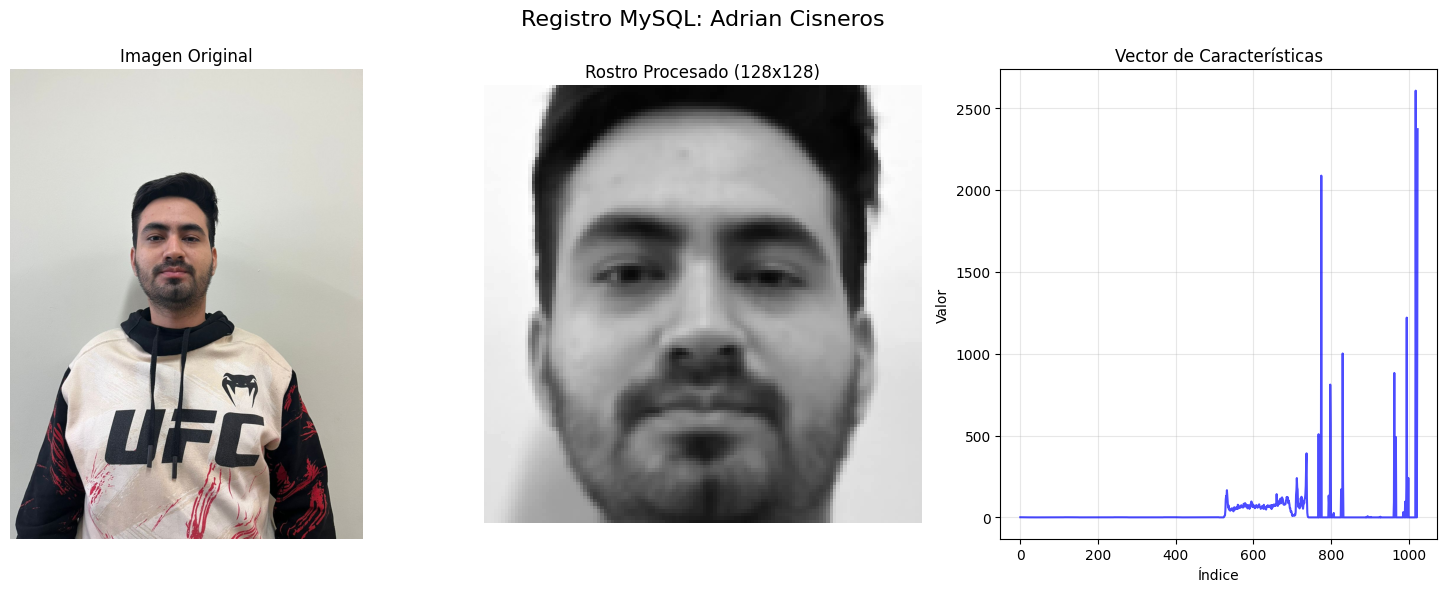

{'persona_id': 1,
 'datos': {'nombre': 'Adrian',
  'apellidos': 'Cisneros',
  'correo': 'acisnerosb1@upao.edu.pe',
  'id_estudiante': '000243425',
  'pk': 'PK_20250603204951_1175'},
 'modelo_archivo': 'modelos/modelo_facial_PK_20250603204951_1175.pkl',
 'json_archivo': 'json_backup/persona_PK_20250603204951_1175.json'}

In [12]:
panel_administracion()